**Importing the required libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

**Uploading the Dataset and unzipping the file**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1) (1).zip


In [3]:
zip_file_name = "archive (1).zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files')

print("Extracted Files and Directories:", os.listdir('/content/extracted_files'))


Extracted Files and Directories: ['FinancialPhraseBank', 'all-data.csv']


**Loading the Dataset**

In [29]:
csv_file_path = '/content/extracted_files/all-data.csv'
try:
    sentiment_data = pd.read_csv(csv_file_path, header=None, names=["sentiment","sentence",], encoding='latin1')
except UnicodeDecodeError:
    print("Unable to decode the file with default encodings. Please check the file format.")
    raise

print(sentiment_data.head())

  sentiment                                           sentence
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


**Preprocessing Sentiment Data**

In [30]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentiment_data['cleaned_sentence'] = sentiment_data['sentence'].apply(preprocess_text)
print(sentiment_data.head())

  sentiment                                           sentence  \
0   neutral  According to Gran , the company has no plans t...   
1   neutral  Technopolis plans to develop in stages an area...   
2  negative  The international electronic industry company ...   
3  positive  With the new production plant the company woul...   
4  positive  According to the company 's updated strategy f...   

                                    cleaned_sentence  
0  according gran company plans move production r...  
1  technopolis plans develop stages area less 100...  
2  international electronic industry company elco...  
3  new production plant company would increase ca...  
4  according company updated strategy years 20092...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Sentiment Mapping**

In [31]:
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
sentiment_data['sentiment_score'] = sentiment_data['sentiment'].map(sentiment_map)

print(sentiment_data.head())

  sentiment                                           sentence  \
0   neutral  According to Gran , the company has no plans t...   
1   neutral  Technopolis plans to develop in stages an area...   
2  negative  The international electronic industry company ...   
3  positive  With the new production plant the company woul...   
4  positive  According to the company 's updated strategy f...   

                                    cleaned_sentence  sentiment_score  
0  according gran company plans move production r...                0  
1  technopolis plans develop stages area less 100...                0  
2  international electronic industry company elco...               -1  
3  new production plant company would increase ca...                1  
4  according company updated strategy years 20092...                1  


**Sentiment Analysis using Transformers (BERT)**

In [32]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

sentiment_data['bert_sentiment'] = sentiment_data['cleaned_sentence'].apply(
    lambda x: sentiment_pipeline(x)[0]['label']
)
print(sentiment_data.head())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


  sentiment                                           sentence  \
0   neutral  According to Gran , the company has no plans t...   
1   neutral  Technopolis plans to develop in stages an area...   
2  negative  The international electronic industry company ...   
3  positive  With the new production plant the company woul...   
4  positive  According to the company 's updated strategy f...   

                                    cleaned_sentence  sentiment_score  \
0  according gran company plans move production r...                0   
1  technopolis plans develop stages area less 100...                0   
2  international electronic industry company elco...               -1   
3  new production plant company would increase ca...                1   
4  according company updated strategy years 20092...                1   

  bert_sentiment  
0        LABEL_0  
1        LABEL_2  
2        LABEL_2  
3        LABEL_0  
4        LABEL_0  


**Load Stock Data**

In [44]:
num_rows = len(sentiment_data)
np.random.seed(42)
stock_data = pd.DataFrame({
    'index': range(num_rows),
    'open': np.random.uniform(100, 200, num_rows),
    'high': np.random.uniform(200, 300, num_rows),
    'low': np.random.uniform(50, 100, num_rows),
    'close': np.random.uniform(100, 200, num_rows),
    'volume': np.random.randint(1000, 5000, num_rows)
})

print("Stock Data:")
print(stock_data.head())

Stock Data:
   index        open        high        low       close  volume
0      0  137.454012  294.777970  69.667642  186.740411    3880
1      1  195.071431  214.119906  92.327539  132.709967    1063
2      2  173.199394  276.351584  71.345266  132.906282    3699
3      3  159.865848  210.868254  77.600909  159.819388    3933
4      4  115.601864  298.125758  61.547083  118.356291    2448


**Merging Sentiment Data and Stock Data**

In [34]:
stock_data['sentiment_score'] = sentiment_data['sentiment_score'].values

print("Combined Data:")
print(stock_data.head())

Combined Data:
   index        open        high        low       close  volume  \
0      0  137.454012  294.777970  69.667642  186.740411    3880   
1      1  195.071431  214.119906  92.327539  132.709967    1063   
2      2  173.199394  276.351584  71.345266  132.906282    3699   
3      3  159.865848  210.868254  77.600909  159.819388    3933   
4      4  115.601864  298.125758  61.547083  118.356291    2448   

   sentiment_score  
0                0  
1                0  
2               -1  
3                1  
4                1  


**Training Predictive Model**

In [39]:
features = stock_data[['open', 'high', 'low', 'volume', 'sentiment_score']]
target = stock_data['close']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 28.827903536127383


**Evaluating Model Performance**

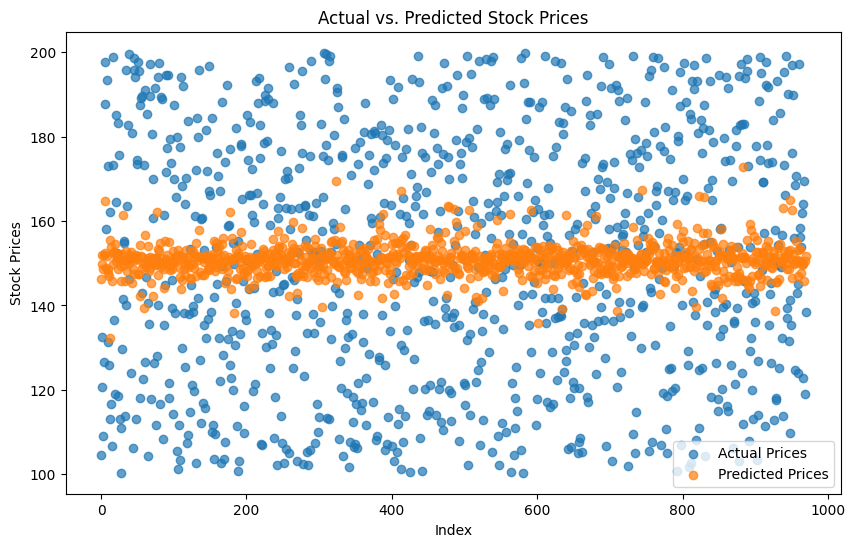

In [41]:
# Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Prices', alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Prices', alpha=0.7)
plt.legend()
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Index")
plt.ylabel("Stock Prices")
plt.show()

**Real-Time Sentiment Integration**

In [45]:
new_sentiment = ['The market is bullish', 'Stocks are down']
new_sentiment_scores = [sentiment_pipeline(text)[0]['label'] for text in new_sentiment]

print("Real-time Sentiment Scores:", new_sentiment_scores)

Real-time Sentiment Scores: ['LABEL_0', 'LABEL_2']


**Sentiment Score vs. Stock Prices**

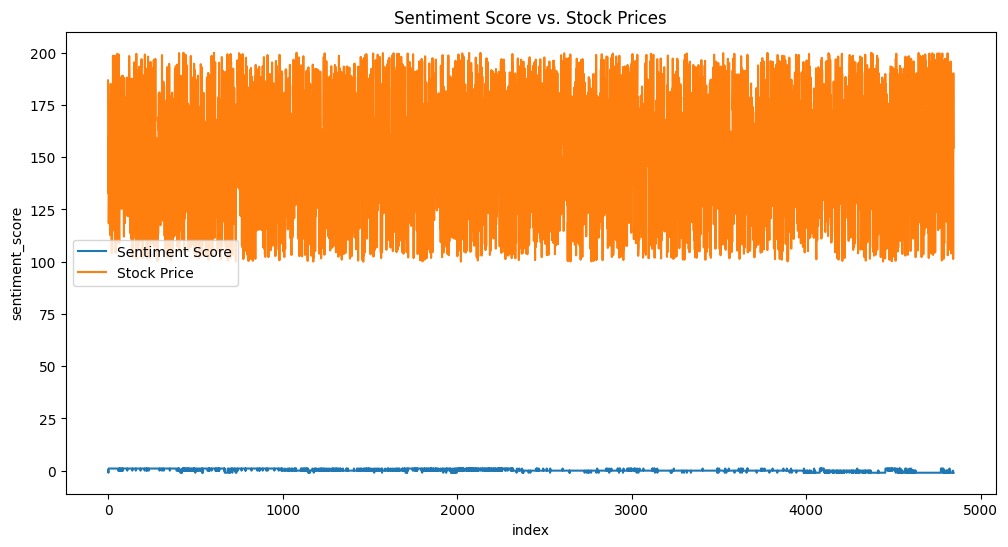

In [40]:
# Sentiment Score vs. Stock Prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=stock_data, x='index', y='sentiment_score', label='Sentiment Score')
sns.lineplot(data=stock_data, x='index', y='close', label='Stock Price')
plt.title("Sentiment Score vs. Stock Prices")
plt.legend()
plt.show()

**Example for checking model performance**

In [42]:
# Example input sentence
input_sentence = "The company has announced strong earnings and plans to expand further into new markets."

sentiment_result = sentiment_pipeline(input_sentence)[0]
sentiment_label = sentiment_result['label']
sentiment_score = {'POSITIVE': 1, 'NEGATIVE': -1, 'NEUTRAL': 0}.get(sentiment_label, 0)

print(f"Sentiment: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score}")

Sentiment: LABEL_2
Sentiment Score: 0


In [43]:
example_features = [150, 200, 120, 3000, sentiment_score]

predicted_stock_price = model.predict([example_features])[0]

print(f"Predicted Stock Price based on sentiment: {predicted_stock_price:.2f}")

Predicted Stock Price based on sentiment: 131.31


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
